This notebook was created in order to add 4 new features to the dataset. These features represent the road types of the network, as they appear in OpenStreetMap. Each of these features is computed as a density of the roads of type $i$ in area $A$: in particular, for area $A$, the density of the roads of type $i$ in $A$ is ratio between the overall length of the roads tagged as $i$ and the overall length of all the roads in $A$.

The road types are the first 3 listed by order of importance [here](https://wiki.openstreetmap.org/wiki/Key:highway):
- motorways
- trunk
- primary roads

In addition to the density of these 3, we added a fourth feature that represents the density of all the "heavy" roads in an area, i.e. the density of all the roads that are either motorway, trunk, or primary roads.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [12]:
PATH_TO_PROCESSED_FILES = '../data/processed/'

gdf_rome_4326 = gpd.read_file(PATH_TO_PROCESSED_FILES + 'Rome_urban_zones_with_features__epsg4326.geojson')
print(gdf_rome_4326.shape)
gdf_rome_4326.head(3)

(155, 24)


,area_code,area_name,SHAPE_Leng,SHAPE_Area,n_traffic_lights,density_traffic_lights,n_shops,density_shops,street_len_tot,street_density,...,density_education_amenities,n_service_amenities,density_service_amenities,n_all_amenities,density_all_amenities,perc_roads_bc,car_accidents,perc_people_far_from_public_transport,pop_density,geometry
0,10L,Morena,22732.760455,8.947226e+06,10.0,1.117665,960,107.295822,90462.509,10.110676,...,0.894132,9,1.005898,48,5.364791,2.447164,182.0,2.8,36.9,"POLYGON ((12.60887 41.83797, 12.61720 41.83477..."
1,10A,Don Bosco,8400.069997,2.256348e+06,17.0,7.534299,1854,821.681815,40177.642,17.806493,...,7.977493,35,15.511793,132,58.501618,2.533784,367.0,93.6,225.9,"POLYGON ((12.55282 41.86608, 12.55302 41.86599..."
2,10B,Appio-Claudio,9265.317994,3.454590e+06,16.0,4.631520,1236,357.784910,34284.729,9.924400,...,3.473640,21,6.078870,112,32.420639,1.465201,239.0,99.8,86.1,"POLYGON ((12.54566 41.86458, 12.54587 41.86452..."


In [3]:
import osmnx as ox
import networkx as nx

PATH_TO_ROAD_NETWORK = '../data/external/rome_drive_service_network.graphml'

In [4]:
## Getting the graph of the entire city of Rome (previously saved in ../data/external/)
G = ox.load_graphml(filepath=PATH_TO_ROAD_NETWORK)

print('> Graph type: ', type(G))
print('> Num of edges: ', G.number_of_edges())
print('> Num of nodes: ', G.number_of_nodes())

> Graph type:  <class 'networkx.classes.multigraph.MultiGraph'>
> Num of edges:  87029
> Num of nodes:  64444


In [10]:
from collections import Counter

def flatten(l):
    x = []
    for i in l:
        if type(i) is list:
            x.extend(i)
        else:
            x.append(i)
    return x

dict_road_to_type = nx.get_edge_attributes(G, 'highway')

print('> Road types: ', Counter(flatten(dict_road_to_type.values())))

> Road types:  Counter({'residential': 42870, 'service': 18201, 'tertiary': 10886, 'secondary': 6066, 'unclassified': 3654, 'primary': 3226, 'motorway_link': 525, 'trunk_link': 410, 'motorway': 351, 'trunk': 344, 'primary_link': 273, 'tertiary_link': 230, 'secondary_link': 208, 'living_street': 116, 'services': 15, 'road': 13, 'crossing': 2, 'rest_area': 1})


In [15]:
%%time

from osmnx.stats import street_length_total


list_density_motorways = []
list_density_trunk = []
list_density_primary = []
list_density_all_heavy = []
i = 0
for c_zone, c_zone_name, c_zone_area in zip(gdf_rome_4326['geometry'], gdf_rome_4326['area_name'], gdf_rome_4326['SHAPE_Area']):
    try:
        # try to take the subgraph describing the road network of the zurrent zone
        G_sub = ox.truncate.truncate_graph_polygon(G, c_zone, retain_all=True)
    except ValueError:
        # this exception is for one zone ('Martignano') which is not urban
        list_density_motorways.append(0)
        list_density_trunk.append(0)
        list_density_primary.append(0)
        list_density_all_heavy.append(0)
        continue
    
    c_zone_area_km = c_zone_area / 1000000
    
    # street length tot
    c_street_length_tot = street_length_total(G_sub)
    c_street_length_tot_km = c_street_length_tot / 1000
    
    # density of certain types of roads
    dict_road_to_type = nx.get_edge_attributes(G_sub, 'highway')
    dict_road_to_length = nx.get_edge_attributes(G_sub, 'length')
    # 1. motorways
    list_motorways_length = [length for road, length in dict_road_to_length.items() if dict_road_to_type[road] == 'motorway']
    sum_motorways_length_km = np.sum(list_motorways_length) / 1000
    c_motorways_density = sum_motorways_length_km / c_street_length_tot_km * 100
    list_density_motorways.append(c_motorways_density)
    # 2. trunk
    list_trunk_length = [length for road, length in dict_road_to_length.items() if dict_road_to_type[road] == 'trunk']
    sum_trunk_length_km = np.sum(list_trunk_length) / 1000
    c_trunk_density = sum_trunk_length_km / c_street_length_tot_km * 100
    list_density_trunk.append(c_trunk_density)
    # 3. primary roads
    list_primary_length = [length for road, length in dict_road_to_length.items() if dict_road_to_type[road] == 'primary']
    sum_primary_length_km = np.sum(list_primary_length) / 1000
    c_primary_density = sum_primary_length_km / c_street_length_tot_km * 100
    list_density_primary.append(c_primary_density)
    # all the three..
    list_all_heavy_length = [length for road, length in dict_road_to_length.items() if dict_road_to_type[road] in ['motorway', 'trunk', 'primary']]
    sum_all_heavy_length_km = np.sum(list_all_heavy_length) / 1000
    c_all_heavy_density = sum_all_heavy_length_km / c_street_length_tot_km * 100
    list_density_all_heavy.append(c_all_heavy_density)
    
    #
    i+=1
    print('processed: %s (%s)' %(i, c_zone_name))
    #

## adding the new column
gdf_rome_4326['motorway_roads_density'] = list_density_motorways
gdf_rome_4326['trunk_roads_density'] = list_density_trunk
gdf_rome_4326['primary_roads_density'] = list_density_primary
gdf_rome_4326['all_heavy_roads_density'] = list_density_all_heavy

print('')
print(gdf_rome_4326.head())
print('')

processed: 1 (Morena)
processed: 2 (Don Bosco)
processed: 3 (Appio-Claudio)
processed: 4 (Quarto Miglio)
processed: 5 (Pignatelli)
processed: 6 (Lucrezia Romana)
processed: 7 (Osteria del Curato)
processed: 8 (Romanina)
processed: 9 (Gregna)
processed: 10 (Barcaccia)
processed: 11 (Appia Antica Sud)
processed: 12 (Marconi)
processed: 13 (Eur)
processed: 14 (Villaggio Giuliano)
processed: 15 (Torrino)
processed: 16 (Laurentino)
processed: 17 (Ciampino)
processed: 18 (Ostiense)
processed: 19 (Valco S. Paolo)
processed: 20 (Garbatella)
processed: 21 (Navigatori)
processed: 22 (Tormarancia)
processed: 23 (Tre Fontane)
processed: 24 (Grottaperfetta)
processed: 25 (Appia Antica Nord)
processed: 26 (Porta Medaglia)
processed: 27 (Cecchignola)
processed: 28 (Mezzocammino)
processed: 29 (Spinaceto)
processed: 30 (Vallerano Castel di Leva)
processed: 31 (Decima)
processed: 32 (Acilia Nord)
processed: 33 (Acilia Sud)
processed: 34 (Palocco)
processed: 35 (Ostia Antica)
processed: 36 (Ostia Nord)


<AxesSubplot:>

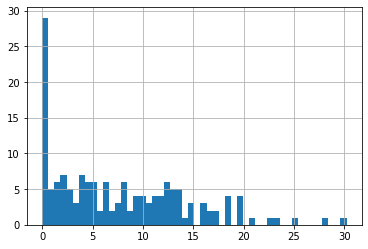

In [18]:
gdf_rome_4326['all_heavy_roads_density'].hist(bins=50)

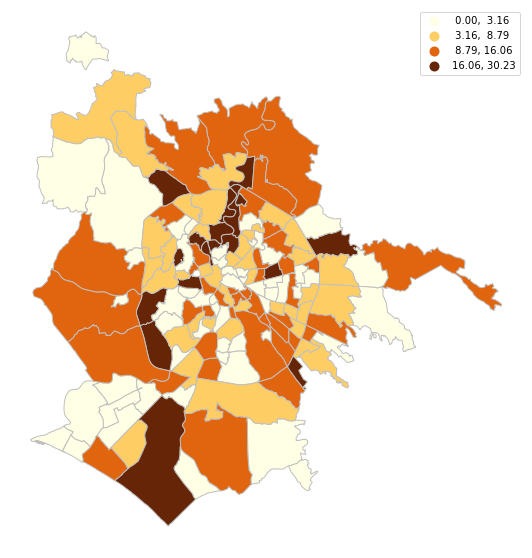

In [22]:
ax = gdf_rome_4326.plot(column='all_heavy_roads_density', 
                         figsize=(10,10), cmap='YlOrBr', edgecolor='silver',
                          scheme='fisher_jenks', k=4, 
                          #missing_kwds={'color': 'lightgrey'}, 
                          legend=True)
ax.set_axis_off()

In [26]:
# changing the ordering of the columns...

gdf_rome_to_save = gdf_rome_4326.drop(['motorway_roads_density', 'trunk_roads_density', 'primary_roads_density', 'all_heavy_roads_density'], axis=1)

gdf_rome_to_save.insert(gdf_rome_to_save.columns.get_loc('motorway_ratio')+1, 'motorway_roads_density', gdf_rome_4326['motorway_roads_density'])
gdf_rome_to_save.insert(gdf_rome_to_save.columns.get_loc('motorway_roads_density')+1, 'trunk_roads_density', gdf_rome_4326['trunk_roads_density'])
gdf_rome_to_save.insert(gdf_rome_to_save.columns.get_loc('trunk_roads_density')+1, 'primary_roads_density', gdf_rome_4326['primary_roads_density'])
gdf_rome_to_save.insert(gdf_rome_to_save.columns.get_loc('primary_roads_density')+1, 'all_heavy_roads_density', gdf_rome_4326['all_heavy_roads_density'])
gdf_rome_to_save.columns

Index(['area_code', 'area_name', 'SHAPE_Leng', 'SHAPE_Area',
       'n_traffic_lights', 'density_traffic_lights', 'n_shops',
       'density_shops', 'street_len_tot', 'street_density', 'motorway_ratio',
       'motorway_roads_density', 'trunk_roads_density',
       'primary_roads_density', 'all_heavy_roads_density', 'n_food_amenities',
       'density_food_amenities', 'n_education_amenities',
       'density_education_amenities', 'n_service_amenities',
       'density_service_amenities', 'n_all_amenities', 'density_all_amenities',
       'perc_roads_bc', 'car_accidents',
       'perc_people_far_from_public_transport', 'pop_density', 'geometry'],
      dtype='object')

In [28]:
# and saving as a GeoJSON (epsg:4326)
gdf_rome_to_save.to_file(PATH_TO_PROCESSED_FILES + 'Rome_urban_zones_with_features__epsg4326.geojson', driver='GeoJSON')

/home/matteo/anaconda3/envs/urbem/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
